In [399]:
from copy import deepcopy
from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

# Support functions

In [292]:
def rmsle(y_test, y_pred):
    y_test = np.log(y_test)
    y_pred = np.log(y_pred)
    return sqrt(mean_squared_error(y_test, y_pred))

In [293]:
# Get score through cross validation. Need for greedy forward selection
def score(X, y, model):
    scores = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        model = deepcopy(model)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        scores.append(rmsle(y_test, y_pred))
    return np.mean(scores)

In [224]:
# Greedy forward selection realisation. This function does features selection in this work
def greedy_forward_selection(data, y, model):
    features = list(data.columns)
    target_features = []
    min_score = np.inf
    for ind in range(len(features)):
        target_feature = None
        for feature in features:
            X = data[np.concatenate((target_features, [feature]))].to_numpy()

            current_score = score(X, y, model)

            if current_score < min_score:
                min_score = current_score
                target_feature = feature
        if target_feature is not None:
            target_features.append(target_feature)
            features.remove(target_feature)
        else:
            return target_features

# Prepare data

In [325]:
# Data download to python notebook
train_data = pd.read_csv("train.csv", index_col=0, header=0)
test_data = pd.read_csv("test.csv", index_col=0, header=0)
y_train = data["SalePrice"]
y_train = y_train.to_numpy()

Get all features. We will use future selection in future

In [229]:
# Features classification
# It's feature, which need to transform to linear form. And after that we'll scale it
binary_to_linear_features = ["LotShape", "LandContour", "Utilities", "LandSlope",
                     "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure","BsmtFinType1", "BsmtFinType2",
                     "HeatingQC", "KitchenQual", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond",
                     "PoolQC", "Fence", "SaleType", "SaleCondition"]
# It'll be convert with one-hot-encoding
multilabel_features = ["MSSubClass", "MSZoning", "Street", "Alley", "LotConfig", "Neighborhood", 
                       "BldgType", "HouseStyle","RoofStyle", "RoofMatl", "MasVnrType", 
                       "Foundation", "Heating", "CentralAir", "Electrical", "Functional", 
                       "GarageType", "PavedDrive", "MiscFeature"]

multiclass_features = ["Condition1", "Condition2", "Exterior1st", "Exterior2nd"]

# It'll be scaled
linear_features = ["LotFrontage", "LotArea", "YearBuilt", "YearRemodAdd", "OverallQual", "OverallCond", 
                   "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
                   "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath",
                   "HalfBath", "KitchenAbvGr", "BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", 
                   "GarageYrBlt", "GarageCars","GarageArea", "WoodDeckSF", "OpenPorchSF", 
                   "EnclosedPorch", "3SsnPorch","ScreenPorch", "PoolArea", "MiscVal", "MoSold", "YrSold"]

In [230]:
# Check data
all_features = []
for features in [binary_to_linear_features, binary_features, 
                 add_binary_features, to_multibinary_feature, linear_features]:
    all_features.extend(features)
all_features = set(all_features)
others_features = set(data.columns) - all_features

print(others_features)

{'SalePrice'}


Error in data description: name of "kitchen" -> 'KitchenAbvGr' and name of 'bedroom' -> 'BedroomAbvGr'

## Preprocess linear features

In [347]:
# Train data prepare block
linear_train_data = train_data[linear_features]
linear_train_data.fillna(0, inplace=True)
scaler = StandardScaler()
temp_matrix = scaler.fit_transform(linear_train_data)
linear_train_data = pd.DataFrame(temp_matrix, index=linear_train_data.index, 
                                 columns=linear_train_data.columns)

/Users/Reshique/anaconda2/lib/python3.7/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [348]:
# Test data prepare block
linear_test_data = test_data[linear_features]
linear_test_data.fillna(0, inplace=True)

temp_matrix = scaler.transform(linear_test_data)
linear_test_data = pd.DataFrame(temp_matrix, index=linear_test_data.index, 
                                 columns=linear_test_data.columns)

/Users/Reshique/anaconda2/lib/python3.7/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


## Preprocess multillabel features

In [349]:
# One-hot-encoding
def one_hot_encoding(data, binary_features):
    binary_data = pd.DataFrame(index=data.index)
    for feature in binary_features:
        pd_binary_data = data[[feature]].dropna(axis=0)

        binarizer = LabelBinarizer()
        one_binary_data = binarizer.fit_transform(pd_binary_data)

        if len(binarizer.classes_) == 2:
            one_binary_data = pd.DataFrame(one_binary_data, index=pd_binary_data.index, columns=[feature])
        else:
            one_binary_data = pd.DataFrame(one_binary_data, index=pd_binary_data.index, 
                                           columns=[f"{feature}_{x}" for x in binarizer.classes_])

        binary_data = pd.merge(binary_data, one_binary_data, how="left", left_index=True, right_index=True)
    binary_data.fillna(0, inplace=True)
    return binary_data

In [350]:
multilabel_train_data = one_hot_encoding(train_data, multilabel_features)
multilabel_test_data = one_hot_encoding(test_data, multilabel_features)

## Process multiclass feature

In [351]:
# Not fine block of code
def transform_multiclass(data, features):
    temp_1 = one_hot_encoding(data, [features[0]])
    temp_1.columns = [f"{x.split('1')[0]}{x.split('1')[1]}" for x in temp_1.columns]

    temp_2 = one_hot_encoding(data, [features[1]])
    temp_2.columns = [f"{x.split('2')[0]}{x.split('2')[1]}" for x in temp_2.columns]

    output = pd.DataFrame(0, index=data.index, columns=list(set(temp_1.columns) | set(temp_2.columns)))
    output = output.add(temp_1, fill_value=0)
    output = output.add(temp_2, fill_value=0)
    return output

In [352]:
multiclass_train_data = pd.DataFrame()
multiclass_train_data = pd.concat([multiclass_train_data, 
                                   transform_multiclass(train_data, ["Condition1", "Condition2"])], axis=1)
multiclass_train_data = pd.concat([multiclass_train_data, 
                                   transform_multiclass(train_data, ["Condition1", "Condition2"])], axis=1)



In [353]:
multiclass_test_data = pd.DataFrame()
multiclass_test_data = pd.concat([multiclass_test_data, 
                                   transform_multiclass(test_data, ["Condition1", "Condition2"])], axis=1)
multiclass_test_data = pd.concat([multiclass_test_data, 
                                   transform_multiclass(test_data, ["Condition1", "Condition2"])], axis=1)



## Preprocess binary to linear features

In [354]:
binary_to_linear_features = ["LotShape", "LandContour", "Utilities", "LandSlope",
                     "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure","BsmtFinType1", 
                        "BsmtFinType2","HeatingQC", "KitchenQual", "FireplaceQu", "GarageFinish", 
                        "GarageQual", "GarageCond","PoolQC", "Fence", "SaleCondition"]

In [365]:
LotShape_dict = {"Reg": 0, "IR1": 1, "IR2": 2, "IR3": 3}
LandContour_dict = {"Lvl": 0, "Bnk": 1, "HLS": 2, "Low": 3}
Utilities_dict = {"AllPub": 0, "NoSewr": 1, "NoSeWa": 2, "ELO": 3}
LandSlope_dict = {"Gtl": 0, "Mod": 1, "Sev": 2}
ExterQual_dict = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4}
ExterCond_dict = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4}
BsmtCond_dict = {np.NaN: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
BsmtQual_dict = {np.NaN: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
BsmtExposure_dict = {"Gd": 0, "Av": 1, "Mn": 2, "No": 3, np.NaN: 4}
BsmtFinType1_dict = {np.NaN: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
BsmtFinType2_dict = {np.NaN: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
HeatingQC_dict = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4}
KitchenQual_dict = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, np.NaN: 5}
FireplaceQu_dict = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, np.NaN: 5}
GarageFinish_dict = {"Fin": 0, "RFn": 1, "Unf": 2, np.NaN: 3}
GarageQual_dict = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, np.NaN: 5}
GarageCond_dict = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, np.NaN: 5}
PoolQC_dict = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, np.NaN: 4}
Fence_dict = {"GdPrv": 0, "MnPrv": 1, "GdWo": 2, "MnWw": 3, np.NaN: 4}
SaleCondition_dict = {"Normal": 0, "Abnorml": 1, "AdjLand": 2, "Alloca": 3, "Family": 4, "Partial": 5}

In [366]:
linear_features_dict = {
    'LotShape': LotShape_dict,
    'LandContour': LandContour_dict,
    'Utilities': Utilities_dict,
    'LandSlope': LandSlope_dict,
    'ExterQual': ExterQual_dict,
    'ExterCond': ExterCond_dict,
    'BsmtQual': BsmtQual_dict,
    'BsmtCond': BsmtCond_dict,
    'BsmtExposure': BsmtExposure_dict,
    'BsmtFinType1': BsmtFinType1_dict,
    'BsmtFinType2': BsmtFinType2_dict,
    'HeatingQC': HeatingQC_dict,
    'KitchenQual': KitchenQual_dict,
    'FireplaceQu': FireplaceQu_dict,
    'GarageFinish': GarageFinish_dict,
    'GarageQual': GarageQual_dict,
    'GarageCond': GarageCond_dict,
    'PoolQC': PoolQC_dict,
    'Fence': Fence_dict,
    'SaleCondition': SaleCondition_dict
}

In [367]:
def transform_binary_to_linear(data, linear_features_dict):
    output_data = pd.DataFrame()
    for column in data.columns:
        temp_data = data[column]
        output_data = pd.concat([output_data, temp_data.replace(linear_features_dict[column])], axis=1)
    return output_data

In [368]:
binary_to_linear_train_data = train_data[binary_to_linear_features]
binary_to_linear_train_data = transform_binary_to_linear(binary_to_linear_train_data, linear_features_dict)

scaler = StandardScaler()
temp_matrix = scaler.fit_transform(binary_to_linear_train_data)
binary_to_linear_train_data = pd.DataFrame(temp_matrix, index=binary_to_linear_train_data.index, 
                                     columns=binary_to_linear_train_data.columns)

binary_to_linear_test_data = test_data[binary_to_linear_features]
binary_to_linear_test_data = transform_binary_to_linear(binary_to_linear_test_data, linear_features_dict)
temp_matrix = scaler.transform(binary_to_linear_test_data)
binary_to_linear_test_data = pd.DataFrame(temp_matrix, index=binary_to_linear_test_data.index, 
                                     columns=binary_to_linear_test_data.columns)


## Put it all together

In [369]:
full_train_data = pd.DataFrame()

# Linear data
full_train_data = pd.concat([full_train_data, linear_train_data], axis=1)

# Multilabel data
full_train_data = pd.concat([full_train_data, multilabel_train_data], axis=1)

# Binary to linear data
full_train_data = pd.concat([full_train_data, binary_to_linear_train_data], axis=1)

# Multiclass data
full_train_data = pd.concat([full_train_data, multiclass_train_data], axis=1)

In [370]:
full_test_data = pd.DataFrame()

# Linear data
full_test_data = pd.concat([full_test_data, linear_test_data], axis=1)

# Multilabel data
full_test_data = pd.concat([full_test_data, multilabel_test_data], axis=1)

# Binary to linear data
full_test_data = pd.concat([full_test_data, binary_to_linear_test_data], axis=1)

# Multiclass data
full_test_data = pd.concat([full_test_data, multiclass_test_data], axis=1)

# Model Check

In [361]:
def create_submission(X_train, y_train, X_test, model, output):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    data = pd.DataFrame(list(zip(X_test.index, y_pred)), columns=["Id", "SalePrice"])
    data.to_csv(output, sep=',', index=None, header=True)

In [362]:
def prepare_data(X_train, X_test, features):
    X_train = X_train[features]
    lost_features = list(set(features) - set(X_test.columns))
    for lost_feature in lost_features:
        X_test[lost_feature] = 0
    X_test = X_test[features]
    return X_train, X_test

## Model №1

1) Full feature dataset

2) Greedy forward selection

3) Linear Regression with default paramets

In [246]:
# Use greedy forward selection
%time
model = LinearRegression()
full_target_features = greedy_forward_selection(full_train_data, y_train, model)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 13.1 µs


In [373]:
X_train = full_train_data[full_target_features].to_numpy()
score(X_train, y_train, model)

0.1489283808007663

In [374]:
model = LinearRegression()
X_train, X_test = prepare_data(full_train_data, full_test_data, full_target_features)
create_submission(X_train, y_train, X_test, model, "./submission_1.txt")

Cross-validation result: 0.14893

Kaggle result: 0.17797

## Model №2

1) Full feature datasets

2) None forward selection

3) Lasso

In [375]:
X_train, X_test = prepare_data(full_train_data, full_test_data, list(full_train_data))
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [376]:
params = {"alpha": [50, 100, 150, 200]}
gcv = GridSearchCV(Lasso(max_iter=30000), param_grid=params, cv=5)

gcv.fit(X_train, y_train)
print(gcv.best_estimator_)

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=30000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [377]:
model = Lasso(max_iter=30000, alpha=100)
score(X_train, y_train, model)

0.15649717997252094

In [378]:
model = Lasso(max_iter=30000, alpha=100)
X_train, X_test = prepare_data(full_train_data, full_test_data, features)
create_submission(X_train, y_train, X_test, model, "./submission_2.txt")

Cross-validation result: 0.15649

Kaggle result: 0.33572

## Model №3

1) Full feature datasets

2) None forward selection

3) Ridge

In [315]:
X_train, X_test = prepare_data(full_train_data, full_test_data, list(full_train_data))
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [319]:
params = {"alpha": [0.5, 1, 1.5, 2]}
gcv = GridSearchCV(Ridge(max_iter=30000), param_grid=params, cv=5)

gcv.fit(X_train, y_train)
print(gcv.best_estimator_)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=30000, normalize=False,
      random_state=None, solver='auto', tol=0.001)


In [320]:
model = Ridge(max_iter=30000, alpha=1)
score(X_train, y_train, model)

0.1707395267489223

In [321]:
model = Ridge(max_iter=30000, alpha=1)
X_train, X_test = prepare_data(full_train_data, full_test_data, features)
create_submission(X_train, y_train, X_test, model, "./submission_3.txt")

Cross-validation result: 0.17073

Kaggle result: 0.33554

## Model №4

1) Full feature datasets

2) Greedy forward selection

3) Ridge

In [379]:
# Use result of greedy forward selection
model = LinearRegression()
X_train, X_test = prepare_data(full_train_data, full_test_data, full_target_features)

In [383]:
params = {"alpha": [0.1, 0.2, 0.5, 0.7, 1]}
gcv = GridSearchCV(Ridge(max_iter=30000), param_grid=params, cv=5)

gcv.fit(X_train, y_train)
print(gcv.best_estimator_)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=30000,
      normalize=False, random_state=None, solver='auto', tol=0.001)


In [385]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [386]:
model = Ridge(max_iter=30000, alpha=1)
score(X_train, y_train, model)

0.14706988874734325

In [389]:
model = Ridge(max_iter=30000, alpha=1)
X_train, X_test = prepare_data(full_train_data, full_test_data, full_target_features)
create_submission(X_train, y_train, X_test, model, "./submission_4.txt")

Cross-validation result: 0.147070

Kaggle result: 0.17152

Best result!

## Model №5

1) Full feature datasets

2) Greedy forward selection

3) Lasso

In [390]:
# Use result of greedy forward selection
model = LinearRegression()
X_train, X_test = prepare_data(full_train_data, full_test_data, full_target_features)

In [393]:
params = {"alpha": [0.1, 1, 5, 10]}
gcv = GridSearchCV(Lasso(max_iter=30000), param_grid=params, cv=5)

gcv.fit(X_train, y_train)
print(gcv.best_estimator_)

Lasso(alpha=5, copy_X=True, fit_intercept=True, max_iter=30000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)


In [394]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [395]:
model = Lasso(max_iter=30000, alpha=5)
score(X_train, y_train, model)

0.14867326977249795

In [397]:
model = Lasso(max_iter=30000, alpha=1)
X_train, X_test = prepare_data(full_train_data, full_test_data, full_target_features)
create_submission(X_train, y_train, X_test, model, "./submission_5.txt")

Cross-validation result: 0.14867

Kaggle result: 0.17758

## Plot data from cross-validation and kaggle

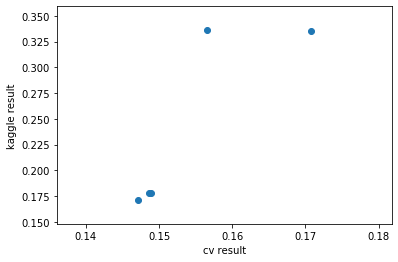

In [402]:
cv_result = [0.14892, 0.15649, 0.17073, 0.14707, 0.14867]
kaggle_result = [0.17797, 0.33572, 0.33554, 0.17152, 0.17758]

plt.scatter(cv_result, kaggle_result)
plt.xlabel("cv result")
plt.ylabel("kaggle result")

plt.show()